In [81]:
import pandas as pd
import numpy as np
import socket
import struct
import pennylane as qml
import base64
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                            ExtraTreesClassifier, GradientBoostingClassifier)
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from pathlib import Path
import json
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

In [82]:
df = pd.read_csv(r"All.csv")
df.head()


,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36707 entries, 0 to 36706
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      36707 non-null  int64  
 1   domain_token_count               36707 non-null  int64  
 2   path_token_count                 36707 non-null  int64  
 3   avgdomaintokenlen                36707 non-null  float64
 4   longdomaintokenlen               36707 non-null  int64  
 5   avgpathtokenlen                  36427 non-null  float64
 6   tld                              36707 non-null  int64  
 7   charcompvowels                   36707 non-null  int64  
 8   charcompace                      36707 non-null  int64  
 9   ldl_url                          36707 non-null  int64  
 10  ldl_domain                       36707 non-null  int64  
 11  ldl_path                         36707 non-null  int64  
 12  ldl_filename      

In [84]:
df.isnull().sum()[df.isnull().sum() > 0]


avgpathtokenlen               280
NumberRate_DirectoryName       10
NumberRate_FileName            10
NumberRate_Extension        10130
NumberRate_AfterPath            3
Entropy_DirectoryName        8468
Entropy_Filename              236
Entropy_Extension              40
Entropy_Afterpath               6
dtype: int64

In [85]:
# First drop the NumberRate_Extension column
df = df.drop('NumberRate_Extension', axis=1)

# Then drop rows with missing values in remaining columns
df = df.dropna()

In [86]:
df.nunique()

Querylength               287
domain_token_count         11
path_token_count           40
avgdomaintokenlen         119
longdomaintokenlen         43
                         ... 
Entropy_DirectoryName    3813
Entropy_Filename         8501
Entropy_Extension        4401
Entropy_Afterpath        3668
URL_Type_obf_Type           5
Length: 79, dtype: int64

In [87]:
from sklearn.preprocessing import LabelEncoder

X = df.drop(columns="URL_Type_obf_Type")
y = df['URL_Type_obf_Type']
# Create encoder
le = LabelEncoder()

# Fit and transform y
y = le.fit_transform(y)
X.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,3,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,3,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,3,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,3,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0
5,0,4,8,5.5,14,6.500000,4,22,10,0,...,3,0,0,-1,0.666676,0.784493,0.814725,0.755658,0.0,-1.0


In [88]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# First handle high correlations
correlation_matrix = X.corr()
high_corr_features = set()  # Keep track of features to drop

# Find features with correlations > 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            # Keep feature with lower mean correlation with other features
            feat1, feat2 = correlation_matrix.columns[i], correlation_matrix.columns[j]
            corr1 = correlation_matrix[feat1].abs().mean()
            corr2 = correlation_matrix[feat2].abs().mean()
            high_corr_features.add(feat1 if corr1 > corr2 else feat2)

# Drop highly correlated features
X_cleaned = X.drop(columns=list(high_corr_features))
print(f"Dropped {len(high_corr_features)} features due to high correlation")

# Now handle VIF
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif_data["VIF"] = vif_data["VIF"].replace([np.inf], 1e10)
    return vif_data.sort_values('VIF', ascending=False)

# Iteratively remove high VIF features
while True:
    vif_data = calculate_vif(X_cleaned)
    if vif_data['VIF'].max() <= 10:
        break
    worst_feature = vif_data.iloc[0]['Feature']
    X_cleaned = X_cleaned.drop(worst_feature, axis=1)
    print(f"Dropped {worst_feature} with VIF: {vif_data.iloc[0]['VIF']:.2f}")

print(f"\nOriginal shape: {X.shape}")
print(f"Final shape: {X_cleaned.shape}")
print(f"\nRemaining features:\n{X_cleaned.columns.tolist()}")


Dropped 38 features due to high correlation
Dropped ISIpAddressInDomainName with VIF: 4742.35
Dropped isPortEighty with VIF: 952.40
Dropped path_token_count with VIF: 478.34
Dropped Entropy_URL with VIF: 325.12
Dropped Entropy_Domain with VIF: 154.15
Dropped SymbolCount_URL with VIF: 110.84
Dropped CharacterContinuityRate with VIF: 62.30
Dropped spcharUrl with VIF: 27.39
Dropped this.fileExtLen with VIF: 24.70
Dropped NumberofDotsinURL with VIF: 20.35
Dropped domainUrlRatio with VIF: 18.27
Dropped argPathRatio with VIF: 10.57

Original shape: (27706, 78)
Final shape: (27706, 28)

Remaining features:
['avgpathtokenlen', 'ldl_domain', 'dld_domain', 'dld_path', 'dld_filename', 'fileNameLen', 'executable', 'Directory_DigitCount', 'File_name_DigitCount', 'Directory_LetterCount', 'Filename_LetterCount', 'Query_LetterCount', 'Domain_LongestWordLength', 'Path_LongestWordLength', 'Arguments_LongestWordLength', 'URL_sensitiveWord', 'delimeter_Domain', 'delimeter_path', 'delimeter_Count', 'Number

In [98]:
X = X_cleaned

In [90]:
# import pennylane as qml
# n_features = X.shape[1]
# N = int(np.ceil(np.log2(n_features)))
# wires = range(N)
# dev = qml.device('default.qubit', wires)    

# @qml.qnode(dev)
# def circuit(f=None):
#     qml.AmplitudeEmbedding(f, wires=wires,pad_with=0,normalize=True)
#     return qml.state()
# X_norm = X.values
# X_quantum = circuit(X_norm)
# X_real = np.real(np.array(X_quantum))
# # Create column names based on index
# column_names = [f'feature_{i}' for i in range(X_real.shape[1])]
# X_real = pd.DataFrame(X_real, columns=column_names)



In [91]:
import pennylane as qml
from pennylane import numpy as np

N = X.shape[1]
wires = range(N)
dev = qml.device("default.qubit", wires)

@qml.qnode(dev)
def circuit(val_list):
    qml.AngleEmbedding(val_list, wires, rotation="Y")
    return [qml.expval(qml.PauliZ(w)) for w in wires]

# Function to process DataFrame through quantum circuit
def quantum_transform(df):
    # Convert DataFrame to numpy array
    values = df.values
    values = values.reshape(values.shape[0], -1)
    # Process each row through quantum circuit
    quantum_features = np.array([circuit(row) for row in values])
    # Remove tensor properties and convert to regular numpy array
    quantum_features = np.array(quantum_features).astype(float)
    return quantum_features
# Transform your data
X_real = quantum_transform(X)


In [92]:
quantum_cols = [f'quantum_state_{i}' for i in range(len(X_real[0]))]
X_real = pd.DataFrame(X_real, columns=quantum_cols)
X_real.head()

In [93]:
# Now use this balanced data for training
X_train, X_test, y_train, y_test = train_test_split(X_real, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# CatBoost
# cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=False)
# cat_model.fit(X_train, y_train)

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [96]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# # Print accuracy
# print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# # Print detailed classification report
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# # Create confusion matrix visualization
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# # Feature importance
# feature_importance = pd.DataFrame({
#     'feature': X.columns,
#     'importance': rf_model.feature_importances_
# }).sort_values('importance', ascending=False)

# print("\nFeature Importance:")
# print(feature_importance)


Random Forest Results:
Accuracy: 0.9486

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       566
           1       0.96      0.97      0.96      1329
           2       0.99      0.94      0.97      1179
           3       0.87      0.95      0.91      1275
           4       0.98      0.95      0.97      1193

    accuracy                           0.95      5542
   macro avg       0.95      0.94      0.95      5542
weighted avg       0.95      0.95      0.95      5542



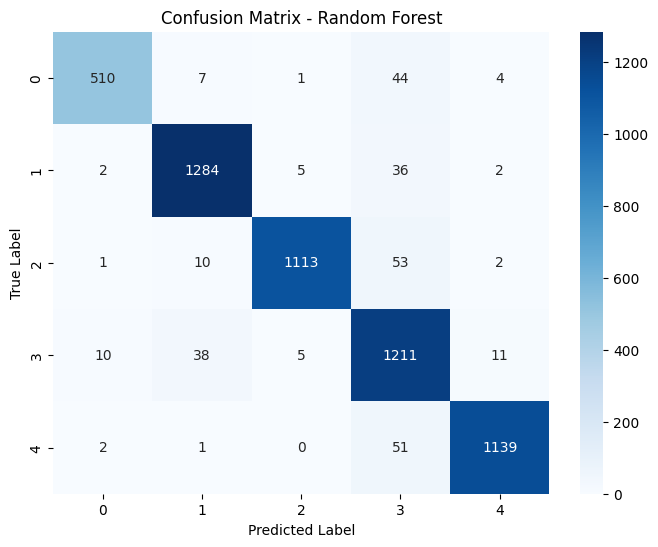


Feature Importance:
       feature  importance
17  feature_17    0.084883
23  feature_23    0.080765
5    feature_5    0.061413
12  feature_12    0.060773
11  feature_11    0.056333
18  feature_18    0.051917
10  feature_10    0.046968
26  feature_26    0.046735
9    feature_9    0.046511
27  feature_27    0.043732
13  feature_13    0.043572
14  feature_14    0.043194
24  feature_24    0.042562
0    feature_0    0.038866
25  feature_25    0.037294
22  feature_22    0.037182
19  feature_19    0.032952
20  feature_20    0.031707
3    feature_3    0.026556
8    feature_8    0.022508
7    feature_7    0.022317
21  feature_21    0.015420
1    feature_1    0.010193
16  feature_16    0.009025
15  feature_15    0.003862
4    feature_4    0.001995
6    feature_6    0.000699
2    feature_2    0.000066
28  feature_28    0.000000
29  feature_29    0.000000
30  feature_30    0.000000
31  feature_31    0.000000

XGBoost Results:
Accuracy: 0.9524

Classification Report:
              precision    re

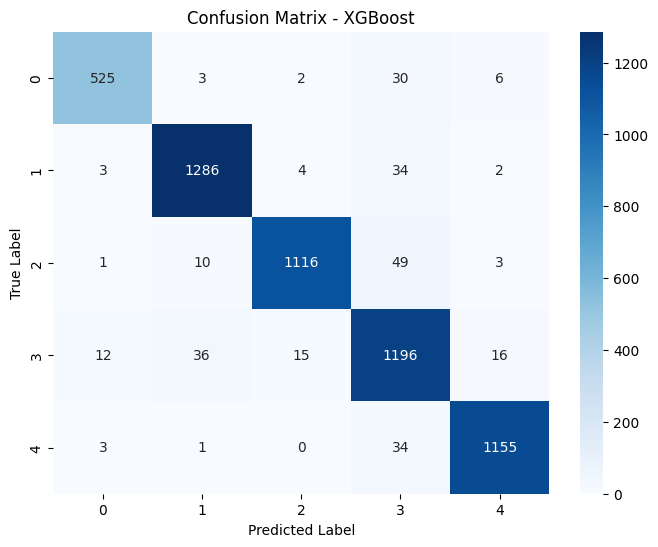


Feature Importance:
       feature  importance
25  feature_25    0.129972
20  feature_20    0.097897
3    feature_3    0.088755
18  feature_18    0.068352
17  feature_17    0.057469
23  feature_23    0.043667
26  feature_26    0.038037
22  feature_22    0.036163
1    feature_1    0.031228
5    feature_5    0.031010
7    feature_7    0.030957
11  feature_11    0.030791
14  feature_14    0.030186
12  feature_12    0.030168
27  feature_27    0.026051
10  feature_10    0.025648
6    feature_6    0.022983
8    feature_8    0.022611
0    feature_0    0.021233
16  feature_16    0.019009
24  feature_24    0.018661
9    feature_9    0.018598
15  feature_15    0.017413
21  feature_21    0.017216
13  feature_13    0.017099
19  feature_19    0.016142
4    feature_4    0.012684
2    feature_2    0.000000
28  feature_28    0.000000
29  feature_29    0.000000
30  feature_30    0.000000
31  feature_31    0.000000

Decision Tree Results:
Accuracy: 0.9172

Classification Report:
              precision

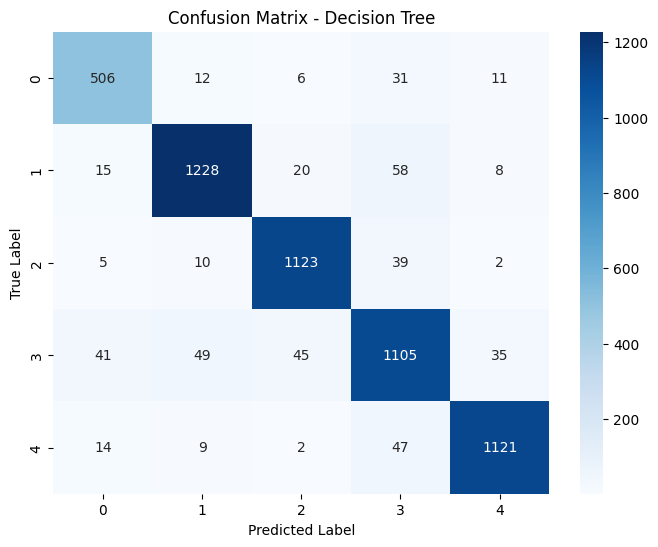


Feature Importance:
       feature  importance
23  feature_23    0.108946
17  feature_17    0.106051
5    feature_5    0.079214
25  feature_25    0.074827
12  feature_12    0.068245
9    feature_9    0.061838
13  feature_13    0.050236
10  feature_10    0.044945
24  feature_24    0.044581
27  feature_27    0.042887
26  feature_26    0.040257
0    feature_0    0.036712
14  feature_14    0.033794
7    feature_7    0.033330
19  feature_19    0.031328
20  feature_20    0.030945
22  feature_22    0.030230
11  feature_11    0.022662
18  feature_18    0.015002
8    feature_8    0.011707
16  feature_16    0.009957
21  feature_21    0.007342
1    feature_1    0.006744
3    feature_3    0.005304
4    feature_4    0.001113
15  feature_15    0.000914
6    feature_6    0.000888
2    feature_2    0.000000
28  feature_28    0.000000
29  feature_29    0.000000
30  feature_30    0.000000
31  feature_31    0.000000


In [97]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns


# Create a dictionary of all models
models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    # 'CatBoost': cat_model,
    'Decision Tree': dt_model
}

# Loop through each model for evaluation
for name, model in models.items():
    predictions = model.predict(X_test)
    
    print(f"\n{'='*50}")
    print(f"{name} Results:")
    print(f"{'='*50}")
    
    # Accuracy
    print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': X_real.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
